# House Prices Kaggle competition - ajrj3

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold

In [2]:
path = r'C:\Users\adam.jackson\Documents\Python\House Prices'
os.chdir(path)

In [3]:
# read in data

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

### Exploratory analysis

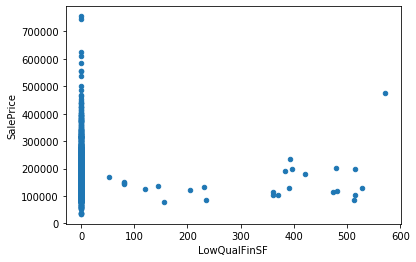

In [6]:
# investigate each numerical variable's correlation with SalesPrice

var = 'LowQualFinSF'
plot_data = pd.concat([train_df[var], train_df['SalePrice']], axis=1)
plot_data.plot.scatter(x=var, y='SalePrice')

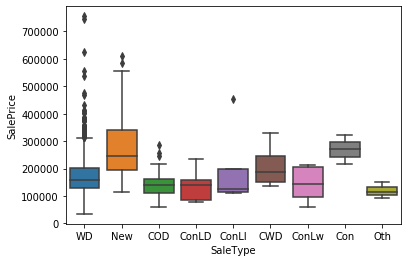

In [7]:
# investigate each categorical variable's correlation with SalesPrice

var = 'SaleType'
plot_data = pd.concat([train_df[var], train_df['SalePrice']], axis=1)
sns.boxplot(x=var, y='SalePrice', data=plot_data)

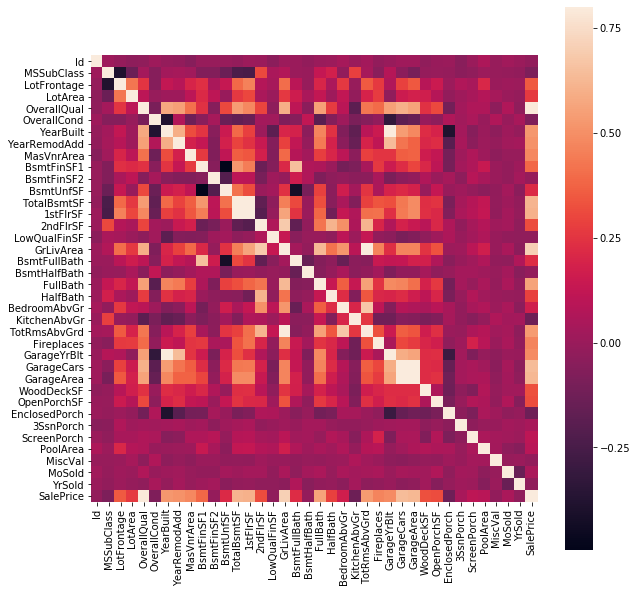

In [4]:
# correlation heat map between input variables

plt.subplots(figsize=(10,10))
corrmat = train_df.corr()
sns.heatmap(corrmat, vmax=0.8, square=True)

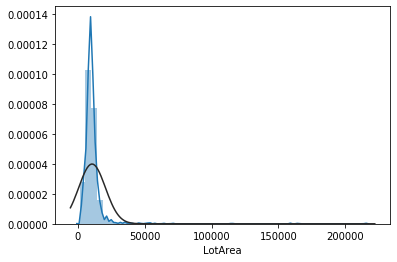

In [5]:
# histogram to examine whether variable is normally distributed or skewed

sns.distplot(train_df['LotArea'], fit=norm)

In [8]:
# check skew of numerical features

print(train_df.select_dtypes(include=['float64', 'int64']).skew())

Id                0.000000
MSSubClass        1.407657
LotFrontage       2.163569
LotArea          12.207688
OverallQual       0.216944
OverallCond       0.693067
YearBuilt        -0.613461
YearRemodAdd     -0.503562
MasVnrArea        2.669084
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
BsmtUnfSF         0.920268
TotalBsmtSF       1.524255
1stFlrSF          1.376757
2ndFlrSF          0.813030
LowQualFinSF      9.011341
GrLivArea         1.366560
BsmtFullBath      0.596067
BsmtHalfBath      4.103403
FullBath          0.036562
HalfBath          0.675897
BedroomAbvGr      0.211790
KitchenAbvGr      4.488397
TotRmsAbvGrd      0.676341
Fireplaces        0.649565
GarageYrBlt      -0.649415
GarageCars       -0.342549
GarageArea        0.179981
WoodDeckSF        1.541376
OpenPorchSF       2.364342
EnclosedPorch     3.089872
3SsnPorch        10.304342
ScreenPorch       4.122214
PoolArea         14.828374
MiscVal          24.476794
MoSold            0.212053
YrSold            0.096269
S

### Feature Engineering

In [9]:
# drop irrelevant columns (those that intuitively shouldn't 
# influence house price greatly, show little correlation, or 
# have few data points/buckets)

cols_to_drop = (['Utilities',
                 'Condition2',
                 'YearRemodAdd',
                 'RoofMatl',
                 'BsmtFinType2',
                 'BsmtFinSF2',
                 'TotalBsmtSF',
                 'Heating',
                 'HeatingQC',
                 'Electrical',
                 'LowQualFinSF',
                 'BsmtFullBath',
                 'BsmtHalfBath',
                 'HalfBath',
                 'GarageCars',
                 'GarageQual',
                 'GarageCond',
                 'GarageYrBlt',
                 'EnclosedPorch',
                 '3SsnPorch',
                 'ScreenPorch',
                 'PoolArea',
                 'PoolQC',
                 'Fence',
                 'MiscFeature',
                 'MiscVal',
                 'MoSold',
                 'YrSold',
                 'SaleType',
                 'SaleCondition',
                 'HouseStyle',
                 'Exterior1st', 
                 'Exterior1st',
                 'Exterior2nd'
                ])

for col in cols_to_drop:
    try:
        train_df.drop([col], axis=1, inplace=True)
        test_df.drop([col], axis=1, inplace=True)
    except:
        continue

train_df.drop(['Id'], axis=1, inplace=True)

In [10]:
# impute zero or missing values

train_df['GarageType'].fillna('None', inplace=True)
train_df['GarageFinish'].fillna('None', inplace=True)

test_df['GarageType'].fillna('None', inplace=True)
test_df['GarageFinish'].fillna('None', inplace=True)

replace_with_zeroes = (['LotFrontage',
                        'Alley',
                        'MasVnrType',
                        'MasVnrArea',
                        '1stFlrSF',
                        '2ndFlrSF',
                        'GrLivArea',
                        'WoodDeckSF',
                        'OpenPorchSF'
                       ])

replace_with_TA = (['BsmtQual',
                    'BsmtCond',
                    'BsmtExposure',
                    'FireplaceQu',
                   ])

for column in replace_with_zeroes:
    train_df[column].fillna(0, inplace=True)
    test_df[column].fillna(0, inplace=True)

for column in replace_with_TA:
    train_df[column].fillna('TA', inplace=True)
    test_df[column].fillna('TA', inplace=True)

In [11]:
# remove outliers

train_df.drop(index=train_df.loc[train_df['BsmtFinSF1']>3000].index, axis=0, inplace=True)
train_df.drop(index=train_df.loc[train_df['1stFlrSF']>3000].index, axis=0, inplace=True)
train_df.drop(index=train_df.loc[train_df['GrLivArea']>4000].index, axis=0, inplace=True)

test_df.drop(index=train_df.loc[train_df['BsmtFinSF1']>3000].index, axis=0, inplace=True)
test_df.drop(index=train_df.loc[train_df['1stFlrSF']>3000].index, axis=0, inplace=True)
test_df.drop(index=train_df.loc[train_df['GrLivArea']>4000].index, axis=0, inplace=True)

In [12]:
# log transform selected columns (those that are skewed)

cols_to_lt = (['1stFlrSF',
               '2ndFlrSF',
               'GrLivArea',
               'WoodDeckSF',
               'OpenPorchSF',
               'MSSubClass',
               'LotFrontage',
               'LotArea',
               'OverallQual',
               'YearBuilt',
               'BsmtFinSF1',
               'BedroomAbvGr',
               'Fireplaces',
               'TotRmsAbvGrd',
              ])

for col in cols_to_lt:
    train_col_min = train_df[col].min()
    if train_col_min == 0:
        train_df[col] = np.log(train_df[col] + 1)
    else:
        train_df[col] = np.log(train_df[col])

for col in cols_to_lt:
    test_col_min = test_df[col].min()
    if test_col_min == 0:
        test_df[col] = np.log(test_df[col] + 1)
    else:
        test_df[col] = np.log(test_df[col])

In [13]:
# one hot encode categorical variables

train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

In [14]:
train_df['SalePrice'] = np.log(train_df['SalePrice'])

### Base Model Investigation

In [15]:
# create train and test datasets

x = train_df.drop(['SalePrice'], axis=1)
y = train_df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

In [16]:
# basic linear regression model

lrm = LinearRegression(normalize=False, fit_intercept=True)
lrm.fit(X_train, y_train)
print("Training set score: {:.2f}".format(lrm.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lrm.score(X_test, y_test)))

Training set score: 0.93
Test set score: 0.91


A simple linear regression model looks pretty reasonable. Let's try slightly more complex regression models to see if they improve performance:

C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


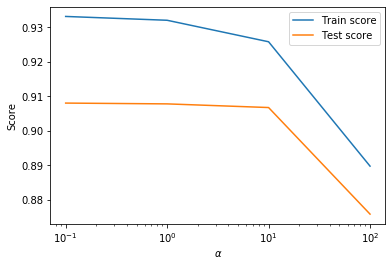

In [17]:
# ridge regression model

alphas = [0.1, 1, 10, 100]
model_list = [None]*len(alphas)
training_scores = [None]*len(alphas)
test_scores = [None]*len(alphas)

for i, alpha in enumerate(alphas):
    model_list[i] = Ridge(alpha=alpha)
    model_list[i].fit(X_train, y_train)
    training_scores[i] = model_list[i].score(X_train, y_train)
    test_scores[i] = model_list[i].score(X_test, y_test)

fig, ax = plt.subplots(1,1)
ax.plot(alphas, training_scores, label='Train score')
ax.plot(alphas, test_scores, label='Test score')
ax.legend(loc='best')
ax.set_xscale('log')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Score')
fig.show()

In [18]:
# optimise hyperparameters for ridge regression, 
# and test higher order features

pipeline = Pipeline([
                     ("poly", PolynomialFeatures()),
                     ("ridge", Ridge())
                    ])

degree = [1, 2]
alpha =  np.logspace(-2,2,5)
parameters = {"poly__degree": degree, "ridge__alpha": alpha}
search = GridSearchCV(estimator=pipeline, param_grid=parameters, cv=5, n_jobs=-1)
search.fit(X_train, y_train)

print(search.best_score_)
print(search.best_params_)

0.9066379256614908
{'poly__degree': 1, 'ridge__alpha': 1.0}


C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [19]:
# kernel ridge regression model

krrm = KernelRidge(alpha=0.1, kernel='polynomial', degree=1, coef0=1)
krrm.fit(X_train, y_train)

degrees = [1, 2, 3, 4]
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 5, 10, 50]
coef0s = [1, 1.5, 2, 2.5, 3]
parameters = {"alpha":alphas, "degree":degrees, "coef0":coef0s}

search = GridSearchCV(estimator=KernelRidge(kernel='polynomial'), param_grid=parameters, cv=5, n_jobs=-1)
search.fit(X_train, y_train)

print(search.best_score_)
print(search.best_params_)

0.9050308117575139
{'alpha': 0.1, 'coef0': 1, 'degree': 1}


C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Similar performance with ridge regression models. Let's see how decision tree models compare:

Text(0, 0.5, 'Score')

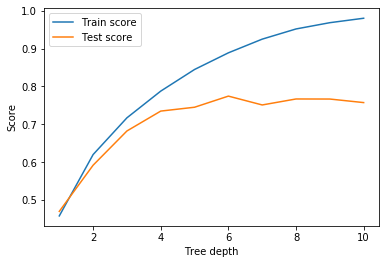

In [20]:
# basic decision tree model

max_depths = np.arange(1, 11, 1)
model_list = [None]*len(max_depths)
training_scores = [None]*len(max_depths)
test_scores = [None]*len(max_depths)

for i, depth in enumerate(max_depths):
    model_list[i] = DecisionTreeRegressor(max_depth=depth, random_state=1)
    model_list[i].fit(X_train, y_train)
    training_scores[i] = model_list[i].score(X_train, y_train)
    test_scores[i] = model_list[i].score(X_test, y_test)

fig, ax = plt.subplots(1,1)
ax.plot(max_depths, training_scores, label='Train score')
ax.plot(max_depths, test_scores, label='Test score')
ax.legend(loc='best')
ax.set_xlabel(r'Tree depth')
ax.set_ylabel('Score')

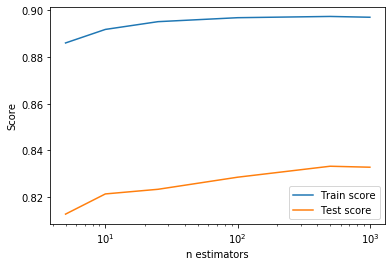

In [21]:
# random forest model

estimators = [5, 10, 25, 100, 500, 1000]
model_list = [None]*len(estimators)
training_scores = [None]*len(estimators)
test_scores = [None]*len(estimators)

for i, n in enumerate(estimators):
    model_list[i] = RandomForestRegressor(max_depth=5, n_estimators=n, n_jobs=-1, random_state=1)
    model_list[i].fit(X_train, y_train)
    training_scores[i] = model_list[i].score(X_train, y_train)
    test_scores[i] = model_list[i].score(X_test, y_test)

fig, ax = plt.subplots(1,1)
ax.plot(estimators, training_scores, label='Train score')
ax.plot(estimators, test_scores, label='Test score')
ax.legend(loc='best')
ax.set_xlabel(r'n estimators')
ax.set_ylabel('Score')
ax.set_xscale('log')

Decision tree models are worse in general, let's now try a gradient-boosting model:

In [22]:
# gradient boosting model

gbr = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100, random_state=1)
gbr.fit(X_train, y_train)

print("Training score is: {:.3f}".format(gbr.score(X_train, y_train)))
print("Test score is: {:.3f}".format(gbr.score(X_test, y_test)))
y_true = y_test
y_pred = gbr.predict(X_test)
print("rmsle: {:.3f}".format(np.sqrt(mean_squared_error(y_true, y_pred))))

Training score is: 0.956
Test score is: 0.900
rmsle: 0.132


This is similar again to the other regression models. Now let's consider an ensemble of these better-performing models.

### Ensemble Models

Credit to the following notebook for the inspiration behind the stacked models:
    
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
    

In [23]:
class WeightedAverage(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, weights):
        self.base_models = base_models
        self.weights = weights
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.base_models]
        
        for model in self.models_:
            model.fit(X,y)
        
        return self
    
    def predict(self, X):
        prediction = 0
        for model, weight in zip(self.models_, self.weights):
            prediction += model.predict(X)*weight
        return prediction

gbr = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100, random_state=1)
rrm = Ridge(alpha=10)
lrm = LinearRegression(normalize=False, fit_intercept=True)
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

wam = WeightedAverage(base_models=(gbr, rrm, lrm, lasso), weights=[0.25, 0.25, 0.25, 0.25])
wam.fit(X_train, y_train)
y_pred = wam.predict(X_test)

print("rmsle weighted average: {:.5f}".format(np.sqrt(mean_squared_error(y_true, y_pred))))

rmsle weighted average: 0.12081


Performance would likely be better if base models were more dissimilar.  Used principally for practice and marginal gains

In [24]:
# ensemble stacked regressor

class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=1)
        
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_idx, holdout_idx in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X.iloc[train_idx,:], y.iloc[train_idx])
                y_pred = instance.predict(X.iloc[holdout_idx,:])
                out_of_fold_predictions[holdout_idx, i] = y_pred
        
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    
    def predict(self, X):
        meta_features =  np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_])
        return self.meta_model_.predict(meta_features)

gbr = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100, random_state=1)
rrm = Ridge(alpha=10)
lrm = LinearRegression(normalize=False, fit_intercept=True)
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

stacked_averaged_models = StackingAveragedModels(base_models = (gbr, rrm, lrm, lasso),
                                                 meta_model = rrm, n_folds=5)
stacked_averaged_models.fit(X_train, y_train)
y_est = stacked_averaged_models.predict(X_test)

print("rmsle weighted average: {:.5f}".format(np.sqrt(mean_squared_error(y_test, y_est))))


rmsle weighted average: 0.12089


In [25]:
# use model on actual test data

test_ids = test_df['Id']
test_df.fillna(value=0, inplace=True)  #two one hot-encoded rows read NaN instead of 0
X_pred = test_df.drop(['Id'], axis=1)
y_pred = np.exp(stacked_averaged_models.predict(X_pred))

submission_df = pd.DataFrame({'Id': test_ids, 'SalePrice': y_pred})
submission_df.to_csv("ajrj3_submission.csv")